# Equi Boots Graphical Notebook

## Library Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/afunnell/Code/EquiBoots/equi_boots/py_scripts


In [2]:
import equiboots as eqb

## Prepping equiboots

In [3]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

Groups created


## ROC AUC by Group (ex. Race)

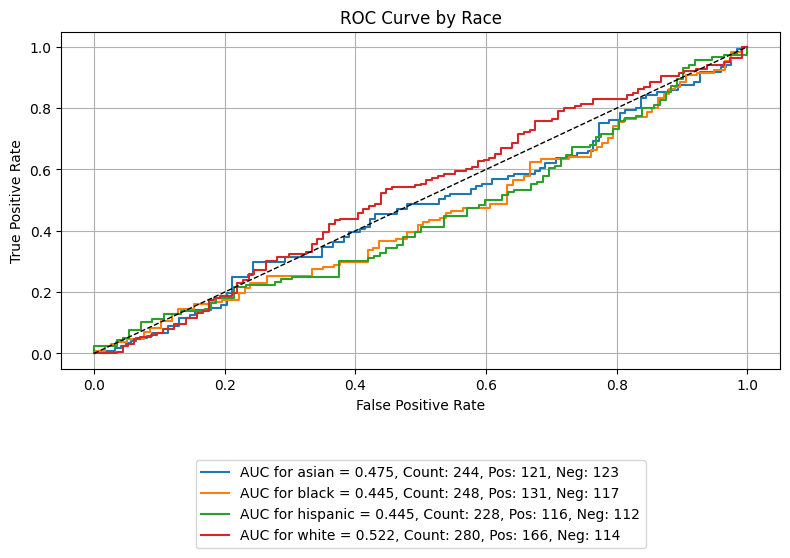

In [4]:
eqb.eq_plot_roc_auc(
    data=sliced_data,
    title="ROC Curve by Race",
    decimal_places=3,
)

## Precision-Recall Curves

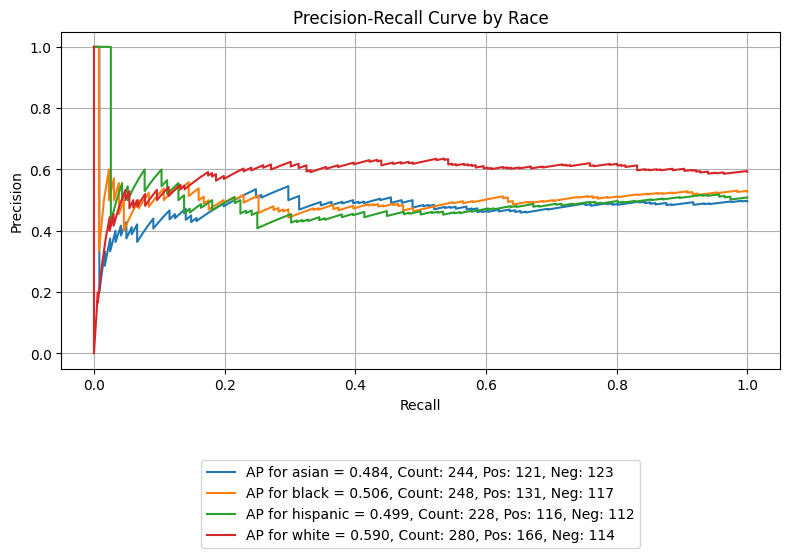

In [5]:
# Precision-Recall plot
fig2 = eqb.eq_plot_precision_recall(
    data=sliced_data,
    title="Precision-Recall Curve by Race",
    # tick_fontsize=8,
    decimal_places=3,
    dpi=100,
)

## Calibration Plot

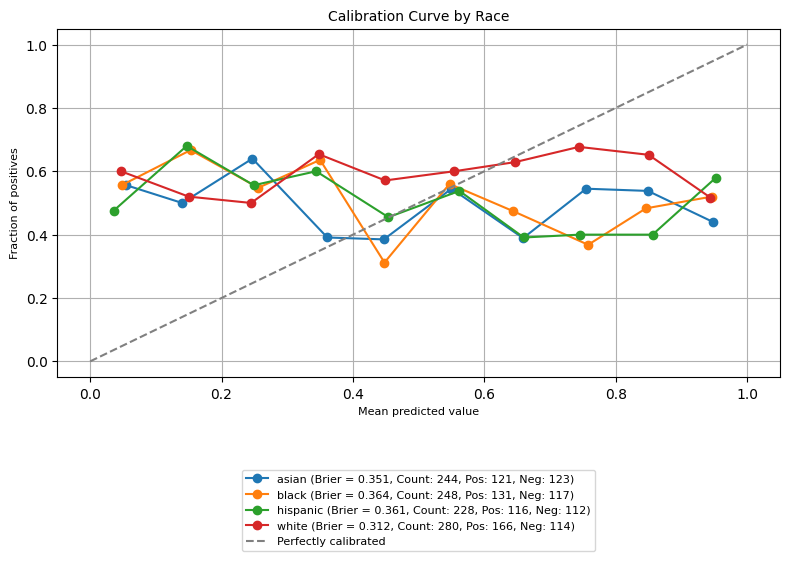

In [6]:
# Calibration plot
fig3 = eqb.eq_calibration_curve_plot(
    data=sliced_data,
    n_bins=10,
    title="Calibration Curve by Race",
    tick_fontsize=8,
    decimal_places=3,
)
fig3

## Bootstrap Graphs

In [7]:
eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
)

# Set seeds
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()

eq2.set_fix_seeds(int_list)

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")
race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 408.72it/s]

Groups created


### Disparity plots

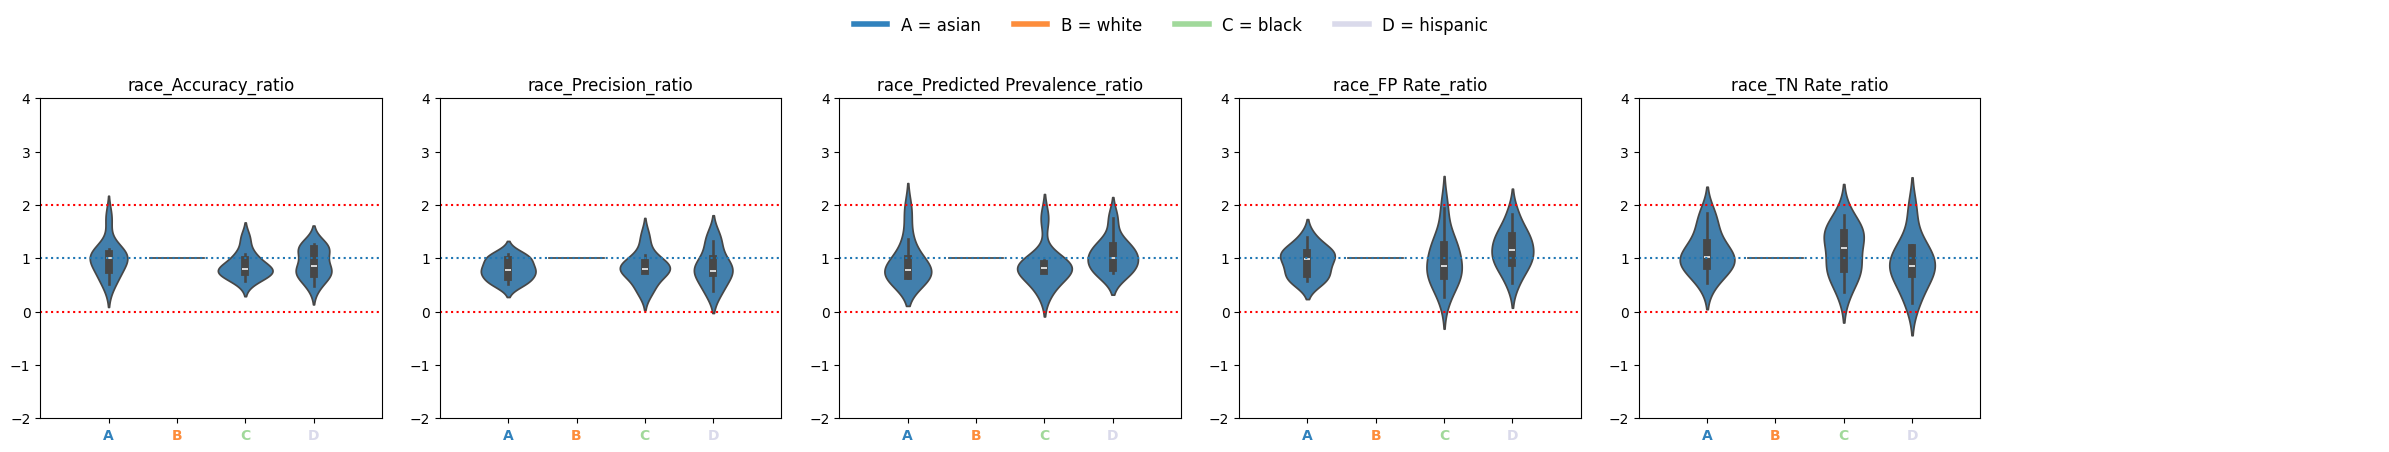

In [10]:
eqb.eq_disparity_metrics_plot(
    dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
    ],
    name="race",
    categories="all",
    figsize=(24, 4),
    plot_kind="violinplot",
)

### ROCAUC Bootstrap

In [9]:
eqb.eq_plot_roc_auc_bootstrap(race_metrics)

/home/afunnell/miniconda3/envs/equiboots/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/afunnell/miniconda3/envs/equiboots/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'